# Import Packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [41]:
X = pd.read_csv('data/train_values.csv', index_col='patient_id')

In [4]:
X.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [8]:
y = pd.read_csv('data/train_labels.csv', index_col='patient_id')['heart_disease_present']

In [7]:
y.head()

,heart_disease_present
patient_id,
0z64un,0
ryoo3j,0
yt1s1x,1
l2xjde,1
oyt4ek,0


# EDA

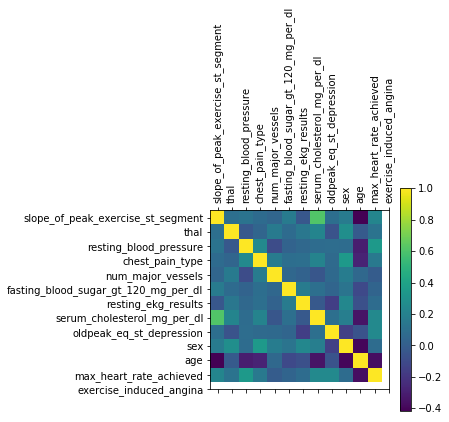

In [17]:
plt.matshow(X.corr())
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.yticks(range(X.shape[1]), X.columns)
plt.colorbar()
plt.show();

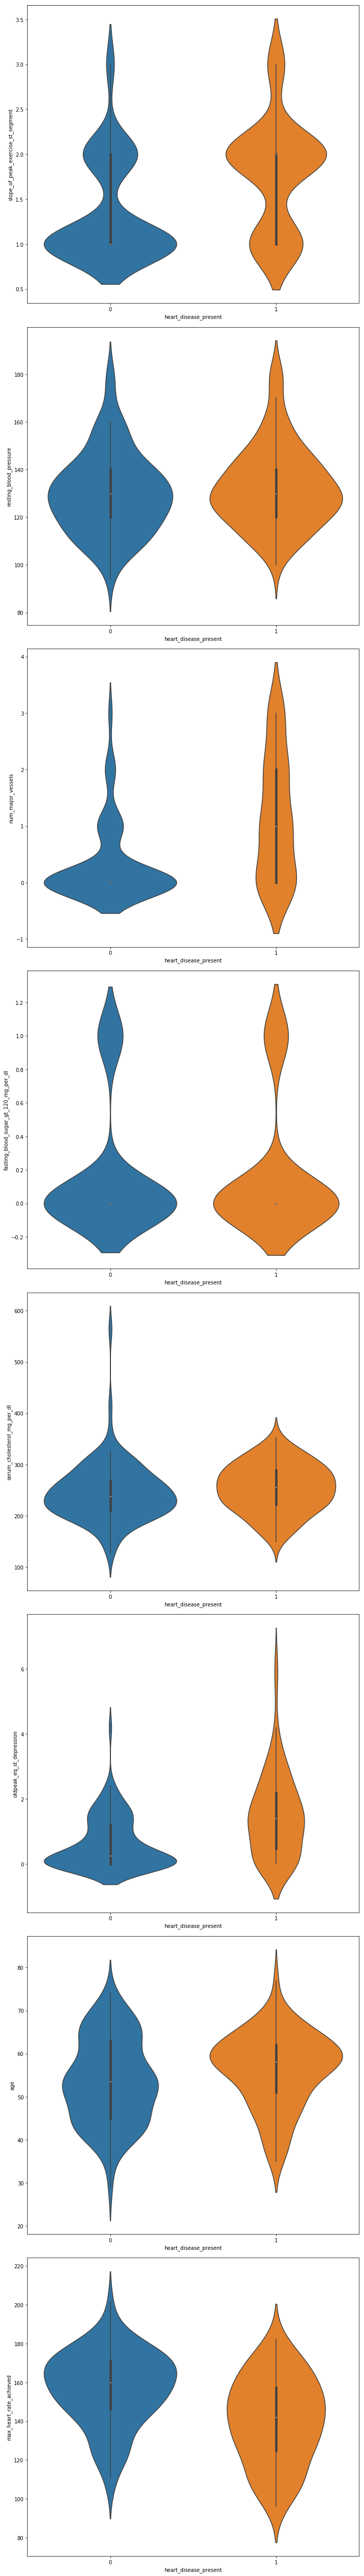

In [43]:
fig, ax = plt.subplots(ncols=1, nrows=len(numerical_features), figsize=(10, 70))

for column in numerical_features:
    ax_num = list(X[numerical_features]).index(column)
    sns.violinplot(y, X[column], ax=ax[ax_num])
    
plt.tight_layout()

# Transformers

In [40]:
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X[self.columns]
    
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.labelers = {col: LabelEncoder().fit(X[col]) for col in X}
        return self
    
    def transform(self, X):
        return pd.DataFrame({col: self.labelers[col].transform(X[col])
                            for col in X})

In [19]:
numerical_features = ['slope_of_peak_exercise_st_segment', 
                      'resting_blood_pressure', 
                      'num_major_vessels',
                      'fasting_blood_sugar_gt_120_mg_per_dl',
                      'serum_cholesterol_mg_per_dl',
                      'oldpeak_eq_st_depression',
                      'age',
                      'max_heart_rate_achieved']

categorical_features = ['thal',
                        'chest_pain_type', 
                        'resting_ekg_results']

binary_features = ['sex',
                   'exercise_induced_angina']

# Logistic Regression

In [20]:
# For categorical features
cat_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(categorical_features)),
    ('cle', CustomLabelEncoder()),
    ('ohe', OneHotEncoder(sparse=False))
])

# For features we don't want to transform
passthrough_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(numerical_features + binary_features))
])

feat_u = FeatureUnion([
    ('cat_pipe', cat_pipe),
    ('passthrough_pipe', passthrough_pipe)
])

In [21]:
full_model = Pipeline([
    ('feat_u', feat_u),
    ('lr', LogisticRegression())
])

In [22]:
full_model.fit(X, y)

C:\Users\surjeet\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\surjeet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('feat_u',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('cat_pipe',
                                                 Pipeline(memory=None,
                                                          steps=[('cst',
                                                                  ColumnSelectTransformer(columns=['thal',
                                                                                                   'chest_pain_type',
                                                                                                   'resting_ekg_results'])),
                                                                 ('cle',
                                                                  CustomLabelEncoder()),
                                                                 ('ohe',
                                                                  OneHotEncoder(categorical_features=None,
           

In [23]:
y_pred = full_model.predict(X)

In [24]:
simple_lr = LogisticRegression()

In [25]:
reduced_cols = ['num_major_vessels', 
                 'slope_of_peak_exercise_st_segment',
                 'max_heart_rate_achieved']

simple_lr.fit(X[reduced_cols],
             y)

y_pred = simple_lr.predict(X[reduced_cols])
log_loss(y, y_pred, labels = None)

C:\Users\surjeet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


8.442887525179907

In [45]:
X.columns

Index(['slope_of_peak_exercise_st_segment', 'thal', 'resting_blood_pressure',
       'chest_pain_type', 'num_major_vessels',
       'fasting_blood_sugar_gt_120_mg_per_dl', 'resting_ekg_results',
       'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina'],
      dtype='object')

In [32]:
param_grid = {'max_depth': range(3,10),
              'min_samples_split': range(3,11,2),
              'min_samples_leaf': range(3,11,2)}

gs = GridSearchCV(RandomForestClassifier(),
                  param_grid=param_grid,
                  n_jobs=-1,
                  cv=3,
                  verbose=1)

In [39]:
gs.fit(X, y)

Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: could not convert string to float: 'normal'

In [ ]:
gs.best_params_

In [ ]:
y_pred = gs.predict(X)

In [ ]:
log_loss(y, y_pred, labels = None)

## Test Values

In [33]:
X_test = pd.read_csv('data/test_values.csv', index_col='patient_id')

In [34]:
y_ans = simple_lr.predict(X_test[reduced_cols])

In [35]:
submission = pd.read_csv('data/submission_format.csv')

In [36]:
submission.heart_disease_present = y_ans / 1.0

In [37]:
submission.to_csv('2019-08-13a_submission.csv', index=False)